# Explore here

In [18]:
import requests
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings

In [3]:
url = "https://api.worldbank.org/v2/country"
params = {"format": "json", "per_page": 50, "page": 1}

r = requests.get(url, params=params, timeout=30)
r.raise_for_status()
payload = r.json()

print("Tipo payload:", type(payload))
print("Keys metadatos:", payload[0].keys())
print("Metadatos:", payload[0])
print("Ejemplo country:", payload[1][0])


Tipo payload: <class 'list'>
Keys metadatos: dict_keys(['page', 'pages', 'per_page', 'total'])
Metadatos: {'page': 1, 'pages': 6, 'per_page': '50', 'total': 296}
Ejemplo country: {'id': 'ABW', 'iso2Code': 'AW', 'name': 'Aruba', 'region': {'id': 'LCN', 'iso2code': 'ZJ', 'value': 'Latin America & Caribbean '}, 'adminregion': {'id': '', 'iso2code': '', 'value': ''}, 'incomeLevel': {'id': 'HIC', 'iso2code': 'XD', 'value': 'High income'}, 'lendingType': {'id': 'LNX', 'iso2code': 'XX', 'value': 'Not classified'}, 'capitalCity': 'Oranjestad', 'longitude': '-70.0167', 'latitude': '12.5167'}


In [4]:
base_url = "https://api.worldbank.org/v2"

# 1. Definimos nuestras variables de búsqueda
paises = "CHL;ARG;USA;DEU;ESP"

indicadores = {
    "SP.POP.TOTL": "Poblacion",
    "NY.GDP.PCAP.CD": "PIB_per_Capita",
    "EN.ATM.CO2E.PC": "CO2_per_Capita",
    "SP.DYN.LE00.IN": "Esperanza_Vida"
}

# 2. Creamos una lista vacía para ir guardando TODO lo que descarguemos
recoleccion_datos = []

# 3. Empezamos el bucle por cada indicador
for codigo, nombre_cod in indicadores.items():
    print(f"Descargando: {nombre_cod}...")
    
    # Construimos la URL dinámica
    url = f"https://api.worldbank.org/v2/country/{paises}/indicator/{codigo}"
    
    # Parámetros: Queremos JSON, datos de 2010 a 2024 y 100 resultados por página
    params = {
        "format": "json",
        "date": "2010:2024",
        "per_page": 100,
    }
    
    # Hacemos la petición
    response = requests.get(url, params=params)
    payload = response.json()
    
    # Verificamos si la respuesta tiene datos (payload[1] no está vacío)
    if len(payload) > 1 and payload[1] is not None:
        # Agregamos los datos de la página a nuestra lista maestra
        recoleccion_datos.extend(payload[1])
    else:
        print(f"Ojo: No se encontraron datos para {nombre_cod}")

print(f"¡Listo! Hemos recolectado {len(recoleccion_datos)} registros.")

Descargando: Poblacion...
Descargando: PIB_per_Capita...
Descargando: CO2_per_Capita...
Ojo: No se encontraron datos para CO2_per_Capita
Descargando: Esperanza_Vida...
¡Listo! Hemos recolectado 225 registros.


In [5]:
print(recoleccion_datos[0])

{'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'}, 'country': {'id': 'AR', 'value': 'Argentina'}, 'countryiso3code': 'ARG', 'date': '2024', 'value': 45696159, 'unit': '', 'obs_status': '', 'decimal': 0}


In [6]:
# Convertimos la lista de diccionarios en un DataFrame "sucio"
df_inicial = pd.DataFrame(recoleccion_datos)

# Creamos el DataFrame limpio extrayendo solo lo que necesitamos
df_limpio = pd.DataFrame()

# Extraemos el nombre del país y el nombre del indicador de los diccionarios
df_limpio['country'] = df_inicial['country'].apply(lambda x: x['value'])
df_limpio['indicator'] = df_inicial['indicator'].apply(lambda x: x['value'])
df_limpio['year'] = df_inicial['date']
df_limpio['value'] = df_inicial['value']

# Mostramos las primeras filas
print(df_limpio.head())

     country          indicator  year       value
0  Argentina  Population, total  2024  45696159.0
1  Argentina  Population, total  2023  45538401.0
2  Argentina  Population, total  2022  45407904.0
3  Argentina  Population, total  2021  45312281.0
4  Argentina  Population, total  2020  45191965.0


In [7]:
# Esto te dirá exactamente cuántos registros hay de cada indicador
print(df_limpio['indicator'].value_counts())

indicator
Population, total                          75
GDP per capita (current US$)               75
Life expectancy at birth, total (years)    75
Name: count, dtype: int64


In [8]:
# Ver el año mínimo y máximo que realmente llegó
print("Año más antiguo:", df_limpio['year'].min())
print("Año más reciente:", df_limpio['year'].max())

Año más antiguo: 2010
Año más reciente: 2024


In [9]:
# 1. Convertir años a enteros
df_limpio['year'] = df_inicial['date'].astype(int)

# 2. Convertir valores a numéricos (si hay nulos, los deja como NaN)
df_limpio['value'] = pd.to_numeric(df_inicial['value'])
pd.options.display.float_format = '{:.2f}'.format

# 3. Eliminar filas donde el valor sea nulo (importante para las gráficas)
df_limpio = df_limpio.dropna(subset=['value'])

print(f"Registros finales: {len(df_limpio)}")
print(df_limpio.sample(5)) # Ver 5 filas al azar

Registros finales: 220
           country                                indicator  year    value
75       Argentina             GDP per capita (current US$)  2024 13969.78
200          Spain  Life expectancy at birth, total (years)  2019    83.83
139  United States             GDP per capita (current US$)  2020 63515.95
107        Germany             GDP per capita (current US$)  2022 50506.52
155      Argentina  Life expectancy at birth, total (years)  2019    76.85


In [10]:
print(df_limpio.groupby('indicator')['year'].count())

indicator
GDP per capita (current US$)               75
Life expectancy at birth, total (years)    70
Population, total                          75
Name: year, dtype: int64


In [11]:
# Estilo de Gráficos
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

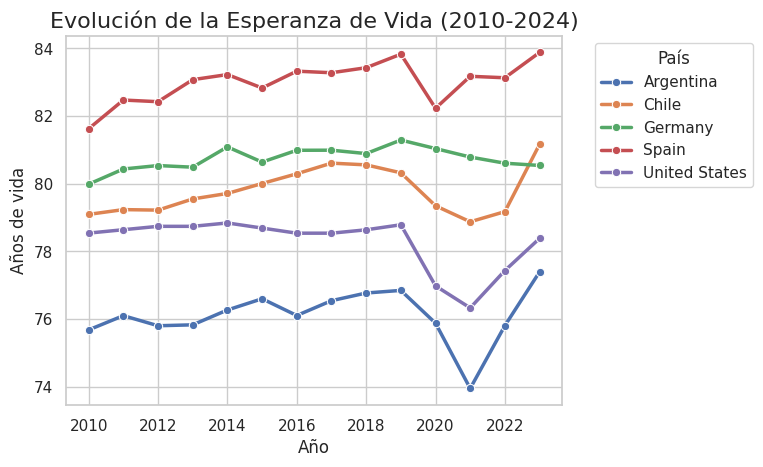

In [12]:
# Filtramos solo Esperanza de Vida
df_vida = df_limpio[df_limpio['indicator'].str.contains('Life expectancy', case=False)]

# Gráfico de líneas para comparar la Esperanza de Vida por país
sns.lineplot(data=df_vida, x='year', y='value', hue='country', marker='o', linewidth=2.5)

plt.title('Evolución de la Esperanza de Vida (2010-2024)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Años de vida', fontsize=12)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

En el siguiente gráfico de líneas podemos ver el orden y la evolución de la esperanza de vida (Argentina, Chile, Alemania, España, Estados Unidos).

Vemos que el país con mayor esperanza de vida es España con aproximandamente 84 años para 2024 y el país con la menor esperanza de vida es Argentina con 75 años para 2024.

Desde 2010 hay un ligero crecimiento en los países seleccionados hasta 2019 donde se ve una fuerte caída que dura hasta 2021, muy probablemente generado por la pandemia del Covid-19 (el país menos afectado fué Alemania).

A partir del 2022 o finales de 2021, se observa una fuerte alza en la esperanza de vida a excepción de Alemania que está con una leve tendencia a la baja.

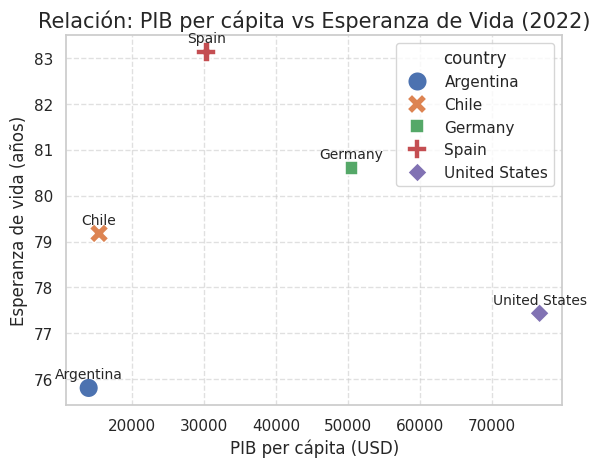

In [13]:
# 1. Filtramos los datos para el año 2022 y los indicadores que nos interesan
df_2021 = df_limpio[df_limpio['year'] == 2022]

# Reiniciamos los nombres de las columnas
df_pivot = df_2021.pivot(index='country', columns='indicator', values='value').reset_index()
df_pivot.columns = ['country', 'pib_per_capita', 'esperanza_vida', 'poblacion']

# 3. Creamos un gráfico de dispersión
sns.scatterplot(
    data=df_pivot, 
    x='pib_per_capita', 
    y='esperanza_vida', 
    hue='country', 
    s=200,     
    style='country'
)

plt.title('Relación: PIB per cápita vs Esperanza de Vida (2022)', fontsize=15)
plt.xlabel('PIB per cápita (USD)', fontsize=12)
plt.ylabel('Esperanza de vida (años)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Añadimos etiquetas de texto para mejor visualización
for i in range(df_pivot.shape[0]):
    plt.text(
        x=df_pivot.pib_per_capita[i], 
        y=df_pivot.esperanza_vida[i] + 0.2,
        s=df_pivot.country[i], 
        fontsize=10, 
        ha='center'
    )

plt.show()

En el siguiente gráfico de dispersión comparamos y analizamos la relación entre el PIB per cápita vs Esperanza de vida por país para el año 2022.

Vemos que el país con mejor eficiencia para 2022 es España que teniendo un PIB per cápita ($30.3K) menor que países como Estados Unidos ($76.7K) y Alemania ($50.5K), tiene una Esperanza de Vida más alta que los países mencionados.

También podemos observar como países una gran diferencia en países como Chile y Argentina que a pesar de tener un PIB per cápita relativamente similar, la esperanza de vida en Chile (79.18 años) es superior a la de Argentina (75.81 años).

In [19]:
# 1. Configuramos para ignorar SOLO este tipo de advertencia molesta
warnings.simplefilter(action='ignore', category=UserWarning)

# 2. Crear el motor (Cumplimos el requisito del profesor)
engine = create_engine("sqlite:///world_bank_analysis.db")

# 3. Sacar la conexión directa ("el cable") del motor
# Esto es necesario para que Pandas no se confunda con las versiones
conn = engine.raw_connection()

# 4. Guardar las tablas (Usamos la variable 'conn')
df_limpio[df_limpio['indicator'].str.contains('GDP', case=False)].to_sql('indicator_gdp_per_capita', con=conn, if_exists='replace', index=False)
df_limpio[df_limpio['indicator'].str.contains('Life expectancy', case=False)].to_sql('indicator_life_expectancy', con=conn, if_exists='replace', index=False)
df_limpio[df_limpio['indicator'].str.contains('Population', case=False)].to_sql('indicator_population', con=conn, if_exists='replace', index=False)

print("Tablas guardadas.")

# 5. Validar (Leer un poquito para ver que funcionó)
print(pd.read_sql("SELECT * FROM indicator_population LIMIT 5", con=conn))

# 6. Cerrar la conexión (Como cerrar un archivo de Word al terminar)
conn.close()

Tablas guardadas.
     country          indicator  year       value
0  Argentina  Population, total  2024 45696159.00
1  Argentina  Population, total  2023 45538401.00
2  Argentina  Population, total  2022 45407904.00
3  Argentina  Population, total  2021 45312281.00
4  Argentina  Population, total  2020 45191965.00
